# Chapter 8

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Review


In [the previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/07_euro.ipynb), we used data from a coin-spinning experiment to estimate the probability that a given coin lands on heads.

We tried three different priors: uniform distributions with 101 and 201 values, and a triangle distribution.  The results are similar, which indicates that we have enough data to "swamp the priors".

And we summarized the posterior distributions three ways, computing the value with Maximum Aposteori Probability (MAP), the posterior mean, and a credible interval.

We'll come back to the Euro problem in another notebook, but first we'll work on the World Cup problem.

## The World Cup problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance Croatia would win?

To answer these questions, we have to make some modeling decisions.

* First, I'll assume that for any team against any other team there is some unknown goal-scoring rate, measured in goals per game, which I'll denote `λ`.

* Second, I'll assume that a goal is equally likely during any minute of a game.  So, in a 90 minute game, the probability of scoring during any minute is `λ/90`.

* Third, I'll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is absolutely true in the real world, but I think they are reasonable simplifications.

As George Box said, "[All models are wrong; some are useful.](https://en.wikipedia.org/wiki/All_models_are_wrong)"

## Goal-scoring

Given these assumptions, we can simulate the goal-scoring process by tossing 90 imaginary coins, one for each minute of the game, with the same probability of yielding a goal.  Here's a function that does it:

In [2]:
def flip(n, p):
    """Flips n coins and returns the number of heads.
    
    n: number of coins
    p: probability of heads
    """
    return np.sum(np.random.random(n) < p)

As an example, suppose we know the goal scoring rate is 1.4; we can compute `p` like this:

In [3]:
λ = 1.4
n = 90
p = λ / n

And call `flip` like this:

In [4]:
flip(n, p)

2

Each time you call flip, you get a different number of goals.  Here's a list of 10 simulated scores:

In [5]:
[flip(n, p) for i in range(10)]

[1, 0, 1, 2, 1, 0, 2, 2, 2, 3]

If we simulate many games, we expect the mean to be near 1.4.

In [6]:
sample = [flip(n, p) for i in range(10000)]

np.mean(sample)

1.3888

This sample contains scores from many simulated games.  The following function computes the number of times each score occurs and stores the result in a Series.

In [7]:
def pmf_from_seq(seq):
    """Make a PMF from a sequence of values.
    
    seq: sequence
    
    returns: Series representing a PMF
    """
    pmf = pd.Series(seq).value_counts(sort=False).sort_index()
    pmf /= pmf.sum()
    return pmf

We can use `pmf_from_seq` to compute the PMF of goals.

In [8]:
pmf_goals = pmf_from_seq(sample)
pmf_goals

0    0.2438
1    0.3526
2    0.2416
3    0.1119
4    0.0374
5    0.0094
6    0.0025
7    0.0007
8    0.0001
dtype: float64

The PMF represents the distribution of goals scored, that is, each possible outcome and its probability.

In this example, the PMF indicates that the probability of scoring 0 goals is about 27%, and the probability of scoring 1 goal is about 35%.

Here's what the whole distribution looks like:

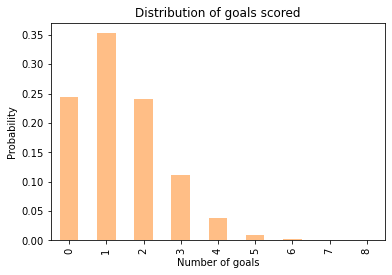

In [9]:
pmf_goals.plot.bar(color='C1', alpha=0.5)

plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Distribution of goals scored');

In summary, if we know the goal-scoring rate, `λ`, we can use `flip` to simulate games and estimate the distribution of goals scored.

## The Poisson distribution

The distribution in the previous section is well approximated by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).  If we know that the goal-scoring rate is $λ$, the probability of scoring $k$ goals is

$f(k; \lambda) = \lambda^k exp(-\lambda) ~/~ k!$

SciPy provides a function that computes this expression; we can use it like this:

In [10]:
from scipy.stats import poisson

xs = pmf_goals.index
ys = poisson.pmf(xs, λ)
ys

array([2.46596964e-01, 3.45235750e-01, 2.41665025e-01, 1.12777012e-01,
       3.94719540e-02, 1.10521471e-02, 2.57883433e-03, 5.15766866e-04,
       9.02592015e-05])

The following figure compares these values with the results we got by simulation.

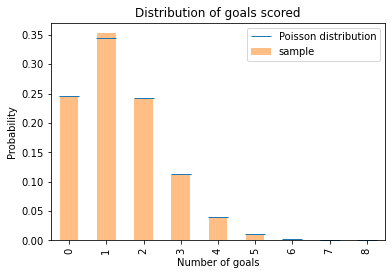

In [11]:
pmf_goals.plot.bar(color='C1', alpha=0.5, label='sample')
plt.plot(xs, ys, '_', color='C0', markersize=20, 
         label='Poisson distribution')

plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Distribution of goals scored')
plt.legend();

The results from the Poisson distribution are consistent with the results from simulation.

In summary, given `λ`, we can compute the distribution of goals scored, either by simulation or using a Poisson distribution.

Now let's turn it around: given the number of goals scored in a game, how can we estimate `λ`?

First, we need a prior distribution for `λ`, which represents the range of possible values and their probabilities before we see the score.

Then we use the data to update the distribution.  

The result is a posterior distribution that represents our estimate of `λ` after seeing the score.

## The prior

If you have ever seen a soccer game, you have some information about `λ`.  In most games, teams score a few goals each.  In rare cases, a team might score more than 5 goals, but they almost never score more than 10.

Using [data from previous World Cups](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/) I estimate that each team scores about 1.4 goals per game, on average.  So I'll set the mean of `λ` to be 1.4.

For a good team against a bad one, we expect `λ` to be higher; for a bad team against a good one, we expect it to be lower.

To model the distribution of goal-scoring rates, I will use a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which I chose because:

1. The goal scoring rate is a continuous quantity that cannot be less than 0, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `α`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. As we'll see, the shape of the Gamma distribution is a reasonable choice, given what we know about soccer.

We can use `scipy.stats.gamma` to compute the values of the gamma distribution, like this:

In [12]:
from scipy.stats import gamma

α = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma.pdf(qs, α)

The parameter, `α`, is the mean of the distribution.

`qs` is an array of possible values for `λ`, from 0 to 10.

`ps` is an array of probabilities, one for each value of `λ`.

Now we can use `qs` and `ps` to make a `Pmf` that represents the prior distribution.

In [13]:
prior = pd.Series(ps, index=qs)
prior /= prior.sum()

I normalized the distribution so the probabilities add up to 1.

We can use the following function, from the previous notebook, to compute the prior mean.

In [14]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [15]:
pmf_mean(prior)

1.4140818156118378

The prior mean is a little higher than 1.4; that's because we are approximating a continuous distribution with an array of discrete values.

But since the choice of prior is partly arbitrary, we don't have to be too precise.

Here's what it looks like.

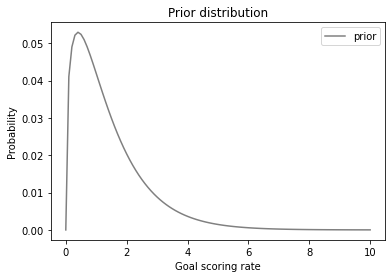

In [16]:
prior.plot(label='prior', color='gray')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Prior distribution')
plt.legend();

This distribution represents our prior knowledge about goal scoring: `λ` is usually less than 2, occasionally as high as 6, and seldom higher than that.  And the mean is about 1.4.

As usual, reasonable people could disagree about the details of the prior.  As an exercise, you'll have a chance to try a different prior and see how much effect it has on the results.

But first, it's time to do an update.

## The update

Suppose you are given the goal-scoring rate, $λ$, and asked to compute the probability of scoring a number of goals, $k$.  That is precisely the question we answered by computing the Poisson distribution:

$ f(k; λ) = \lambda^k \exp(-\lambda) ~/~ k! $

For example, if $λ$ is 1.4, the probability of scoring 4 goals in a game is:

In [17]:
k = 4
poisson.pmf(4, λ)

0.039471954028253146

Now suppose we are have an array of possible values for λ, like this:

In [18]:
λs = prior.index

We can compute the likelihood of the data for each hypothetical value of λ, like this:

In [19]:
k = 4
likelihood = poisson.pmf(k, λs)

And that's all we need to do the update.  

Here's the function we used in the previous notebook; it takes a prior distribution and an array of likelihoods, does a Bayesian update, and returns the total probability of the data.

In [20]:
def bayes_update(pmf, likelihood):
    """Do a Bayesian update.
    
    pmf: Series that represents the prior
    likelihood: sequence of likelihoods
    
    returns: float probability of the data
    """
    pmf *= likelihood
    prob_data = pmf.sum()
    pmf /= prob_data
    return prob_data

In the example, France scored 4 goals, so I'll make a copy of the prior and update it with the likelihoods we just computed.

In [21]:
france = prior.copy()
bayes_update(france, likelihood)

0.05015532557804499

Under the prior distribution, the probability of scoring 4 goals was about 5%.

Here's what the posterior distribution looks like:

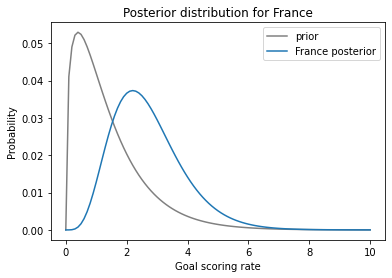

In [22]:
prior.plot(label='prior', color='gray')
france.plot(label='France posterior', color='C0')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Posterior distribution for France')
plt.legend();

The data, `k=4`, makes us think higher values of `λ` are more likely and lower values are less likely.  So the posterior distribution is shifted to the right.

Remember that the prior mean was about 1.4; here's the posterior mean:

In [23]:
pmf_mean(prior), pmf_mean(france)

(1.4140818156118378, 2.699772393342308)

The posterior mean is near 2.7, which is between the prior (1.4) and the data (4).

Having seen 4 goals, we think France's goal-scoring rate is higher than 1.4, but we have not seen enough data to go all the way to 4.

**Exercise:** Here's a prior distribution for Croatia:

In [24]:
croatia = prior.copy()

Update `croatia` with the observed number of goals, `k=2`.  Plot the results and compute the posterior mean.

In [25]:
# Solution goes here

In [26]:
# Solution goes here

In [27]:
# Solution goes here

## Summary

In this notebook, I introduced the World Cup problem, which involves estimating the goal-scoring rate of a soccer team, based on the outcome of a single game.

To solve this problem, I introduced the gamma distribution, which we used to generate a prior, and the Poisson distribution, which we used to compute the likelihood of the data.

We used the prior and the likelihood to do a Bayesian update, which computes posterior distributions that estimate the goal-scoring rate for each team.

[In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/09_predict.ipynb) we will use those distributions to answer the questions we started with:

1. What is the probability that the winning team is actually the better team?

2. What is their probability of winning a rematch?


**Exercise:**  I chose to represent the prior distribution with a gamma distribution because it has some desirable properties, but it is not the only choice.

Another possibility is a normal distribution with the same mean, 1.4 goals per game, and a standard deviation we can choose.

You can evaluate the PDF of the normal distribution like this:

In [28]:
from scipy.stats import norm

mean = 1.4
std = 1.4
qs = np.linspace(0, 10, 101)
ps = norm.pdf(qs, mean, std)

Use these values to construct a normal prior, then update it with France's score, `k=4`.  Plot the posterior distributions based on the gamma and uniform priors.  How different are they?  What effect does the choice of `std`?

In [29]:
# Solution goes here

In [30]:
# Solution goes here

In [31]:
# Solution goes here

In [32]:
# Solution goes here